In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

import xgboost as xgb # Extreme Gradient Boosting Algorithm
import pickle # Saving the model
import json # json file w/r

from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, cross_val_score, train_test_split, RandomizedSearchCV, GridSearchCV, learning_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import LabelEncoder

import shap # Shap values

import os

# Upload data

In [2]:
# metadata
md = pd.read_csv('metadata.tsv', sep='\t', index_col=[0])

# Define mappings for each cat 
layer_mapping = {'SRF': 0, 'DCM': 1, 'MES': 2}
layer2_mapping = {'EPI': 0, 'MES': 1}
polar_mapping = {'non polar': 0, 'polar': 1}
#province_mapping = {'B2': 0, 'B3': 1, 'B5': 2, 'B6': 3, 'B7': 4, 'B8': 5}

# Copy of metadata to encode
md_encoded = md.copy()
# Map categorical values
md_encoded['Layer'] = md_encoded['Layer'].map(layer_mapping)
md_encoded['Layer2'] = md_encoded['Layer2'].map(layer2_mapping)
md_encoded['polar'] = md_encoded['polar'].map(polar_mapping)
#md_encoded['Province'] = md_encoded['Province'].map(province_mapping)

# CLR implementation

In [3]:
def clr_(data, eps=1e-6):
    """
    Perform centered log-ratio (clr) normalization on a dataset.

    Parameters:
    data (pandas.DataFrame): A DataFrame with samples as rows and components as columns.

    Returns:
    pandas.DataFrame: A clr-normalized DataFrame.
    """
    if (data < 0).any().any():
        raise ValueError("Data should be strictly positive for clr normalization.")

    # Add small amount to cells with a value of 0
    if (data <= 0).any().any():
        data = data.replace(0, eps)

    # Calculate the geometric mean of each row
    gm = np.exp(data.apply(np.log).mean(axis=1))

    # Perform clr transformation
    clr_data = data.apply(np.log).subtract(np.log(gm), axis=0)

    return clr_data

# SHAP (SRF) polar / non polar

In [4]:
private_list = ['TSC021', # TARA_031 non polar
                'TSC060', # TARA_042 non polar
                'TSC085', # TARA_065 non polar
                'TSC102', # TARA_068 non polar
                'TSC141', # TARA_084 polar south
                'TSC145', # TARA_085 polar south
                'TSC173', # TARA_112 non polar
                'TSC213', # TARA_132 non polar
                'TSC216', # TARA_133 non polar
                'TSC237', # TARA_150 non polar
                'TSC261', # TARA_189 polar
                'TSC276', # TARA_208 polar
                'TSC285', # TARA_163 polar
               ] 
# 8 non polar, 5 polar

def shap_polar_(matrix_type):
    # Load the matrix data
    df = pd.read_csv(f'matrices2/Matrix_{matrix_type}_srf.tsv', sep='\t', index_col=[0])
    
    # Load the corresponding model
    filename = f'model_{matrix_type}_srf_polar'
    with open(f'models/{filename}.pkl', 'rb') as file:
        model = pickle.load(file)
    
    # Compute centered log ratio transformation, assuming the function clr_ is predefined
    clr_df = clr_(df)
    aligned_md = md_encoded.loc[clr_df.index]  # Align the target metadata with the current dataframe's indices
    y_total = aligned_md['polar']  # POLAR (0/1)
    
    # SHAP analysis
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(clr_df.loc[private_list])

    # Calculate mean SHAP values for each feature for each class
    mean_shap_values_per_class = [np.abs(shap_values[i]).mean(axis=0) for i in range(len(shap_values))]

    # Reverse polar mapping, assuming polar_mapping is predefined
    reverse_polar_mapping = {v: k for k, v in polar_mapping.items()}

    # Create DataFrame for easier plotting
    feature_names = clr_df.columns
    unique_labels = y_total.unique()
    unique_labels.sort()  # Sort the labels if they are not in order
    class_names = ['Class ' + reverse_polar_mapping[label] for label in unique_labels]
    shap_df = pd.DataFrame(np.array(mean_shap_values_per_class).T, columns=class_names, index=feature_names)

    # Calculate total mean SHAP value for each feature
    shap_df['Total Mean SHAP'] = shap_df.sum(axis=1)

    # Sort the DataFrame based on Total Mean SHAP value
    shap_df_sorted = shap_df.sort_values(by='Total Mean SHAP', ascending=True)

    # Select only the top n features
    top_n = 15
    shap_df_top = shap_df_sorted.tail(top_n)

    # Drop the total column for plotting the top n features
    shap_df_top = shap_df_top.drop(columns=['Total Mean SHAP'])
    
    return shap_df_top

# Usage example for different matrix types
matrix_types = ['MX', 'M0', 'M1', 'guidi', 'salazar', 'stress']
#results_polar = {matrix_type: shap_polar_(matrix_type) for matrix_type in matrix_types}
results_polar_total = {matrix_type: shap_polar_(matrix_type).sum(axis=1) for matrix_type in matrix_types}
#results_polar_total

[09:42:53] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[09:42:53] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[09:42:53] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[09:42:53] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[09:42:53] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: 

# SHAP (SRF) temperature

In [5]:
private_list = ['TSC021', # TARA_031 non polar, HIGH
                'TSC060', # TARA_042 non polar, HIGH
                'TSC085', # TARA_065 non polar, MID
                'TSC102', # TARA_068 non polar, MID
                'TSC141', # TARA_084 polar south, LOW
                'TSC145', # TARA_085 polar south, LOW
                'TSC173', # TARA_112 non polar, HIGH
                'TSC213', # TARA_132 non polar, HIGH
                'TSC216', # TARA_133 non polar, MID
                'TSC237', # TARA_150 non polar, MID
                'TSC261', # TARA_189 polar, LOW
                'TSC276', # TARA_208 polar, LOW
                'TSC285', # TARA_163 polar, LOW
               ]
# 4 HIGH, 4 MID, 5 LOW

def shap_temperature_(matrix_type):
    # Load the matrix data
    df = pd.read_csv(f'matrices2/Matrix_{matrix_type}_srf.tsv', sep='\t', index_col=[0])
    
    # Load the corresponding model
    filename = f'model_{matrix_type}_srf_temperature'
    with open(f'models/{filename}.pkl', 'rb') as file:
        model = pickle.load(file)
    
    # Compute centered log ratio transformation, assuming the function clr_ is predefined
    clr_df = clr_(df)
    aligned_md = md_encoded.loc[clr_df.index]  # Align the target metadata with the current dataframe's indices
    # Create the target variable for the entire dataset of the biological samples' index
    continuous_y = aligned_md['Temperature'].copy()
    #y_total = pd.qcut(continuous_y, 3, labels=False)
    y_total = continuous_y.apply(lambda temp: 0 if temp < 10 else (1 if temp <= 22 else 2))
    
    # SHAP analysis
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(clr_df.loc[private_list])
    
    temperature_bin_labels = {
        0: 'Class <10°C',
        1: 'Class 10-22°C',
        2: 'Class >22°C'
    }
    
    # Calculate mean SHAP values for each feature for each class
    mean_shap_values_per_class = [np.abs(shap_values[i]).mean(axis=0) for i in range(len(shap_values))]
    
    # Creating a DataFrame for easier plotting with the correct class names
    feature_names = clr_df.columns
    unique_labels = y_total.unique()
    unique_labels.sort()  # Sort the labels if they are not in order
    class_names = [temperature_bin_labels[label] for label in unique_labels]
    shap_df = pd.DataFrame(np.array(mean_shap_values_per_class).T, columns=class_names, index=feature_names)
    
    # Calculate total mean SHAP value for each feature
    shap_df['Total Mean SHAP'] = shap_df.sum(axis=1)
    
    # Sort the DataFrame based on Total Mean SHAP value
    shap_df_sorted = shap_df.sort_values(by='Total Mean SHAP', ascending=True)
    
    # Select only the top n features
    top_n = 15
    shap_df_top = shap_df_sorted.tail(top_n)
    
    # Drop the total column for plotting the top n features
    shap_df_top = shap_df_top.drop(columns=['Total Mean SHAP'])
    
    return shap_df_top

# Usage example for different matrix types
matrix_types = ['MX', 'M0', 'M1', 'guidi', 'salazar', 'stress']
#results_temperature = {matrix_type: shap_temperature_(matrix_type) for matrix_type in matrix_types}
results_temperature_total = {matrix_type: shap_temperature_(matrix_type).sum(axis=1) for matrix_type in matrix_types}
#results_temperature_total

[09:42:53] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[09:42:53] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[09:42:53] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[09:42:53] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[09:42:54] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: 

# SHAP (SRF) province

In [6]:
private_list = ['TSC021', # TARA_031 non polar
                'TSC060', # TARA_042 non polar
                'TSC085', # TARA_065 non polar
                'TSC102', # TARA_068 non polar
                #'TSC141', # TARA_084 polar south
                'TSC145', # TARA_085 polar south
                'TSC173', # TARA_112 non polar
                'TSC184', # TARA_122 non polar
                'TSC213', # TARA_132 non polar
                'TSC216', # TARA_133 non polar
                'TSC237', # TARA_150 non polar
                'TSC261', # TARA_189 polar
                'TSC276', # TARA_208 polar
                #'TSC285', # TARA_163 polar
               ] 

def shap_province_(matrix_type):
    # Load the matrix data
    df = pd.read_csv(f'matrices2/Matrix_{matrix_type}_srf.tsv', sep='\t', index_col=[0])
    
    # Load the corresponding model
    filename = f'model_{matrix_type}_srf_province'
    with open(f'models/{filename}.pkl', 'rb') as file:
        model = pickle.load(file)
    
    # Compute centered log ratio transformation, assuming the function clr_ is predefined
    clr_df = clr_(df)
    aligned_md = md_encoded.loc[clr_df.index]  # Align the target metadata with the current dataframe's indices
    y_total = aligned_md['Province']

    # Extract and sort the unique labels
    unique_labels = sorted(y_total.unique())
    le = LabelEncoder()
    le.fit(unique_labels)
    y_encoded = le.transform(y_total)
    
    # SHAP analysis
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(clr_df.loc[private_list])  # clr_df.loc[private_list] should be your feature matrix
    
    # Calculate mean SHAP values for each feature for each class
    mean_shap_values_per_class = [np.abs(shap_values[i]).mean(axis=0) for i in range(len(shap_values))]
    
    # Creating a DataFrame for easier plotting
    feature_names = clr_df.columns  # Ensure this is the correct list of features
    
    # Correct class names for the model
    model_classes = model.classes_
    original_labels = le.inverse_transform(model_classes)
    class_names = ['Class ' + label for label in original_labels]
    
    shap_df = pd.DataFrame(np.array(mean_shap_values_per_class).T, columns=class_names, index=feature_names)
    
    # Calculate total mean SHAP value for each feature
    shap_df['Total Mean SHAP'] = shap_df.sum(axis=1)
    
    # Sort the DataFrame based on Total Mean SHAP value
    shap_df_sorted = shap_df.sort_values(by='Total Mean SHAP', ascending=True)
    
    # Select only the top n features
    top_n = 15
    shap_df_top = shap_df_sorted.tail(top_n)
    
    # Drop the total column for plotting the top n features
    shap_df_top = shap_df_top.drop(columns=['Total Mean SHAP'])
    
    return shap_df_top

# Usage example for different matrix types
matrix_types = ['MX', 'M0', 'M1', 'guidi', 'salazar', 'stress']
#results_temperature = {matrix_type: shap_province_(matrix_type) for matrix_type in matrix_types}
results_province_total = {matrix_type: shap_province_(matrix_type).sum(axis=1) for matrix_type in matrix_types}
#results_province_total

[09:42:54] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[09:42:54] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[09:42:54] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[09:42:54] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[09:42:54] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: 

# SHAP (Non Polar) layer

In [7]:
private_list = ['TSC021', # TARA_031 SRF
                
                'TSC058', # TARA_042 DCM
                'TSC060', # TARA_042 SRF
                
                'TSC081', # TARA_065 DCM
                'TSC083', # TARA_065 MES
                'TSC085', # TARA_065 SRF
                
                'TSC096', # TARA_068 DCM
                'TSC099', # TARA_068 MES
                'TSC102', # TARA_068 SRF
                
                #'TSC142', # TARA_085 DCM
                #'TSC144', # TARA_085 MES
                #'TSC145', # TARA_085 SRF
                
                'TSC171', # TARA_112 DCM
                'TSC172', # TARA_112 MES
                'TSC173', # TARA_112 SRF
                
                'TSC211', # TARA_132 DCM
                'TSC212', # TARA_132 MES
                'TSC213', # TARA_132 SRF
                
                'TSC214', # TARA_133 DCM
                'TSC215', # TARA_133 MES
                'TSC216', # TARA_133 SRF
                
                'TSC236', # TARA_150 DCM
                'TSC237', # TARA_150 SRF
                
                #'TSC261', # TARA_189 SRF
                #'TSC262', # TARA_189 DCM
                #'TSC263', # TARA_189 MES
               ] 
# 8 SRF, 7 DCM, 5 MES

def shap_layer_(matrix_type):
    # Load the matrix data
    df = pd.read_csv(f'matrices2/Matrix_{matrix_type}_nonpolar.tsv', sep='\t', index_col=[0])
    
    # Load the corresponding model
    filename = f'model_{matrix_type}_nonpolar_layer'
    with open(f'models/{filename}.pkl', 'rb') as file:
        model = pickle.load(file)
    
    # Compute centered log ratio transformation, assuming the function clr_ is predefined
    clr_df = clr_(df)
    aligned_md = md_encoded.loc[clr_df.index]  # Align the target metadata with the current dataframe's indices
    y_total = aligned_md['Layer']
    
    # SHAP analysis
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(clr_df.loc[private_list])  # clr_df.loc[private_list] should be your feature matrix
    
    # Calculate mean SHAP values for each feature for each class
    mean_shap_values_per_class = [np.abs(shap_values[i]).mean(axis=0) for i in range(len(shap_values))]
    
    # Reverse layer mapping to get the original labels
    reverse_layer_mapping = {v: k for k, v in layer_mapping.items()}
    
    # Creating a DataFrame for easier plotting
    feature_names = clr_df.columns
    unique_labels = y_total.unique()
    unique_labels.sort()  # Sort the labels if they are not in order
    # Update class names using the reverse mapping
    class_names = ['Class ' + reverse_layer_mapping[label] for label in unique_labels]
    
    shap_df = pd.DataFrame(np.array(mean_shap_values_per_class).T, columns=class_names, index=feature_names)
    
    # Calculate total mean SHAP value for each feature
    shap_df['Total Mean SHAP'] = shap_df.sum(axis=1)
    
    # Sort the DataFrame based on Total Mean SHAP value
    shap_df_sorted = shap_df.sort_values(by='Total Mean SHAP', ascending=True)
    
    # Select only the top n features
    top_n = 15
    shap_df_top = shap_df_sorted.tail(top_n)
    
    # Drop the total column for plotting the top n features
    shap_df_top = shap_df_top.drop(columns=['Total Mean SHAP'])
    
    return shap_df_top

# Usage example for different matrix types
matrix_types = ['MX', 'M0', 'M1', 'guidi', 'salazar', 'stress']
#results_temperature = {matrix_type: shap_layer_(matrix_type) for matrix_type in matrix_types}
results_layer_total = {matrix_type: shap_layer_(matrix_type).sum(axis=1) for matrix_type in matrix_types}
#results_layer_total

[09:42:54] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[09:42:54] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[09:42:54] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[09:42:54] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[09:42:54] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: 

{'MX': TtrR         0.020515
 CsoR         0.020540
 ZntR         0.021474
 LldR         0.022275
 ExuR_UxuR    0.023856
 Irr          0.030022
 PdxR         0.037483
 LiuQ         0.051570
 NagQ         0.063034
 LexA         0.068322
 NrdR         0.073918
 PhnR         0.153943
 FadR         0.183402
 CadR-PbrR    0.270445
 GlcC         0.523923
 dtype: float32,
 'M0': PhnR         0.233552
 GntR         0.235895
 GulR         0.255018
 FadR         0.263320
 LiuQ         0.270797
 NrtR         0.287176
 BirA         0.311930
 QorR         0.337858
 HutC         0.341352
 PaaR         0.399922
 PdxR         0.413662
 FixJ         0.426890
 ExuR_UxuR    0.490161
 FnrN_FixK    0.746086
 MetR         1.239259
 dtype: float32,
 'M1': HrcA         0.186745
 GntR         0.188853
 MerR         0.209402
 Irr          0.256809
 Rex          0.305054
 HexR         0.316804
 QorR         0.332084
 NadQ         0.334984
 SahR_SamR    0.393899
 LexA         0.430108
 FadP         0.446332
 VanR

# SHAP (Non Polar) layer2

In [8]:
private_list = ['TSC021', # TARA_031 SRF
                
                'TSC058', # TARA_042 DCM
                'TSC060', # TARA_042 SRF
                
                'TSC081', # TARA_065 DCM
                'TSC083', # TARA_065 MES
                'TSC085', # TARA_065 SRF
                
                'TSC096', # TARA_068 DCM
                'TSC099', # TARA_068 MES
                'TSC102', # TARA_068 SRF
                
                #'TSC142', # TARA_085 DCM
                #'TSC144', # TARA_085 MES
                #'TSC145', # TARA_085 SRF
                
                'TSC171', # TARA_112 DCM
                'TSC172', # TARA_112 MES
                'TSC173', # TARA_112 SRF
                
                'TSC211', # TARA_132 DCM
                'TSC212', # TARA_132 MES
                'TSC213', # TARA_132 SRF
                
                'TSC214', # TARA_133 DCM
                'TSC215', # TARA_133 MES
                'TSC216', # TARA_133 SRF
                
                'TSC236', # TARA_150 DCM
                'TSC237', # TARA_150 SRF
                
                #'TSC261', # TARA_189 SRF
                #'TSC262', # TARA_189 DCM
                #'TSC263', # TARA_189 MES
               ] 
# 8 SRF, 7 DCM, 5 MES

def shap_layer2_(matrix_type):
    # Load the matrix data
    df = pd.read_csv(f'matrices2/Matrix_{matrix_type}_nonpolar.tsv', sep='\t', index_col=[0])
    
    # Load the corresponding model
    filename = f'model_{matrix_type}_nonpolar_layer2'
    with open(f'models/{filename}.pkl', 'rb') as file:
        model = pickle.load(file)
    
    # Compute centered log ratio transformation, assuming the function clr_ is predefined
    clr_df = clr_(df)
    aligned_md = md_encoded.loc[clr_df.index]  # Align the target metadata with the current dataframe's indices
    y_total = aligned_md['Layer2']
    
    # SHAP analysis
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(clr_df.loc[private_list])  # clr_df.loc[private_list] should be your feature matrix
    
    # Calculate mean SHAP values for each feature for each class
    mean_shap_values_per_class = [np.abs(shap_values[i]).mean(axis=0) for i in range(len(shap_values))]
    
    # Reverse layer mapping to get the original labels
    reverse_layer2_mapping = {v: k for k, v in layer2_mapping.items()}
    
    # Creating a DataFrame for easier plotting
    feature_names = clr_df.columns
    unique_labels = y_total.unique()
    unique_labels.sort()  # Sort the labels if they are not in order
    # Update class names using the reverse mapping
    class_names = ['Class ' + reverse_layer2_mapping[label] for label in unique_labels]
    
    shap_df = pd.DataFrame(np.array(mean_shap_values_per_class).T, columns=class_names, index=feature_names)
    
    # Calculate total mean SHAP value for each feature
    shap_df['Total Mean SHAP'] = shap_df.sum(axis=1)
    
    # Sort the DataFrame based on Total Mean SHAP value
    shap_df_sorted = shap_df.sort_values(by='Total Mean SHAP', ascending=True)
    
    # Select only the top n features
    top_n = 15
    shap_df_top = shap_df_sorted.tail(top_n)
    
    # Drop the total column for plotting the top n features
    shap_df_top = shap_df_top.drop(columns=['Total Mean SHAP'])
    
    return shap_df_top

# Usage example for different matrix types
matrix_types = ['MX', 'M0', 'M1', 'guidi', 'salazar', 'stress']
#results_temperature = {matrix_type: shap_layer_(matrix_type) for matrix_type in matrix_types}
results_layer2_total = {matrix_type: shap_layer2_(matrix_type).sum(axis=1) for matrix_type in matrix_types}
#results_layer2_total

[09:42:55] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[09:42:55] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[09:42:55] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[09:42:55] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[09:42:55] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: 

{'MX': IscR    0.000000
 GguR    0.000000
 Zur     0.000000
 HutC    0.000000
 HrcA    0.000000
 HisR    0.000000
 HexR    0.000000
 HcpR    0.000000
 GulR    0.000000
 HypR    0.000000
 TtrR    0.094121
 FadR    0.138151
 GntR    0.161868
 PaaR    0.207338
 GlcC    1.619367
 dtype: float32,
 'M0': HcpR    0.000000
 HisR    0.000000
 IscR    0.010569
 AgaR    0.023001
 ModE    0.025712
 SiaR    0.048586
 FadR    0.058851
 GlcC    0.066470
 GulR    0.068933
 GguR    0.091011
 GntR    0.178242
 PdxR    0.239273
 NrtR    0.375199
 PaaR    0.389966
 MetR    0.834008
 dtype: float32,
 'M1': VanR         0.144306
 NnrR         0.170412
 PaaR         0.209542
 AgaR         0.214865
 CblR         0.223563
 SahR_SamR    0.236667
 GntR         0.238211
 IscR         0.270528
 Rex          0.270767
 PdxR         0.277848
 GulR         0.394797
 LexA         0.415748
 KdgR         0.577672
 MerR         0.586863
 BirA         0.641633
 dtype: float32,
 'guidi': LexA    0.095941
 GntR    0.101913
 

# SHAP (EPI - NonPolar) NO3

In [9]:
private_list = ['TSC018',
                'TSC068',
                'TSC126',
                'TSC184',
                'TSC233',
                
    
                'TSC138',
                'TSC159',
                'TSC217',
               ]

def shap_no3_(matrix_type):
    # Load the matrix data
    df = pd.read_csv(f'matrices2/Matrix_{matrix_type}_epi-nonpolar.tsv', sep='\t', index_col=[0])
    
    # Load the corresponding model
    filename = f'model_{matrix_type}_epi-nonpolar_no3'
    with open(f'models/{filename}.pkl', 'rb') as file:
        model = pickle.load(file)
    
    # Compute centered log ratio transformation, assuming the function clr_ is predefined
    clr_df = clr_(df)
    aligned_md = md_encoded.loc[clr_df.index]
    aligned_md['NO3_bins'] = aligned_md['NO3'].apply(lambda temp: 0 if temp <= 7 else 1)
    y_total = aligned_md['NO3_bins']
    
    # SHAP analysis
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(clr_df.loc[private_list])  # clr_df.loc[private_list] should be your feature matrix
    
    no3_bin_labels = {
    0: 'Class <=7 NO3',
    1: 'Class > NO3'
    }
    
    # Calculate mean SHAP values for each feature for each class
    mean_shap_values_per_class = [np.abs(shap_values[i]).mean(axis=0) for i in range(len(shap_values))]
    
    # Creating a DataFrame for easier plotting
    feature_names = clr_df.columns  # Ensure this is the correct list of features
    unique_labels = y_total.unique()
    unique_labels.sort()  # Sort the labels if they are not in order
    class_names = [no3_bin_labels[label] for label in unique_labels]
    
    shap_df = pd.DataFrame(np.array(mean_shap_values_per_class).T, columns=class_names, index=feature_names)
    
    # Calculate total mean SHAP value for each feature
    shap_df['Total Mean SHAP'] = shap_df.sum(axis=1)
    
    # Sort the DataFrame based on Total Mean SHAP value
    shap_df_sorted = shap_df.sort_values(by='Total Mean SHAP', ascending=True)
    
    # Select only the top n features
    top_n = 15
    shap_df_top = shap_df_sorted.tail(top_n)
    
    # Drop the total column for plotting the top n features
    shap_df_top = shap_df_top.drop(columns=['Total Mean SHAP'])
    
    return shap_df_top

# Usage example for different matrix types
matrix_types = ['MX', 'M0', 'M1', 'guidi', 'salazar', 'stress']
#results_temperature = {matrix_type: shap_no3_(matrix_type) for matrix_type in matrix_types}
results_no3_total = {matrix_type: shap_no3_(matrix_type).sum(axis=1) for matrix_type in matrix_types}
#results_no3_total

[09:42:55] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[09:42:55] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[09:42:55] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[09:42:55] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[09:42:55] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: 

{'MX': NmlR    0.072488
 CcpA    0.076420
 NorR    0.088819
 NagR    0.092482
 PaaR    0.096345
 TtrR    0.108213
 QorR    0.117734
 HcpR    0.119976
 RbsR    0.153749
 AmtR    0.176352
 BioQ    0.186849
 VanR    0.204575
 PhsR    0.251510
 MetJ    0.259095
 DasR    0.469776
 dtype: float32,
 'M0': NikR         0.021617
 DasR         0.029764
 LtbR         0.030776
 ExuR_UxuR    0.030793
 SdaR         0.031013
 FadR         0.046682
 PaaR         0.047319
 AcnR         0.052572
 VanR         0.056494
 CadR-PbrR    0.057189
 NnrR         0.108220
 NorR         0.127338
 NagR         0.129022
 AmtR         0.141237
 BioQ         0.252656
 dtype: float32,
 'M1': FadR         0.011363
 AmtR         0.011447
 RbkR         0.013775
 NiaR         0.017017
 DasR         0.017940
 HrcA         0.019928
 GntR         0.034161
 PhnR         0.043100
 SdaR         0.069136
 NorR         0.099660
 NmlR         0.102143
 TyrR         0.111725
 PhsR         0.171085
 CzrA         0.197377
 CadR-PbrR 

# SHAP (EPI - NonPolar) NPP

In [10]:
private_list = ['TSC021', # TARA_031 SRF
                
                'TSC058', # TARA_042 DCM
                'TSC060', # TARA_042 SRF
                
                'TSC081', # TARA_065 DCM
                'TSC085', # TARA_065 SRF
                
                'TSC096', # TARA_068 DCM
                'TSC102', # TARA_068 SRF
                
                'TSC171', # TARA_112 DCM
                'TSC173', # TARA_112 SRF
                
                'TSC211', # TARA_132 DCM
                'TSC213', # TARA_132 SRF
                
                'TSC214', # TARA_133 DCM
                'TSC216', # TARA_133 SRF
                
                'TSC236', # TARA_150 DCM
                'TSC237', # TARA_150 SRF
               ] 

def shap_npp_(matrix_type):
    # Load the matrix data
    df = pd.read_csv(f'matrices2/Matrix_{matrix_type}_epi-nonpolar.tsv', sep='\t', index_col=[0])
    
    # Load the corresponding model
    filename = f'model_{matrix_type}_epi-nonpolar_npp'
    with open(f'models/{filename}.pkl', 'rb') as file:
        model = pickle.load(file)
    
    # Compute centered log ratio transformation, assuming the function clr_ is predefined
    clr_df = clr_(df)
    aligned_md = md_encoded.loc[clr_df.index]  # Align the target metadata with the current dataframe's indices
    aligned_md['NPP_bins'] = aligned_md['NPP 8d VGPM (mgC/m2/day)'].apply(lambda temp: 0 if temp < 275 else (1 if temp <= 540 else 2))
    y_total = aligned_md['NPP_bins']
    
    # SHAP analysis
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(clr_df.loc[private_list])  # clr_df.loc[private_list] should be your feature matrix
        
    npp_bin_labels = {
        0: 'Class <275 NPP',
        1: 'Class 275-540 NPP',
        2: 'Class >540 NPP'
    }
    
    # Calculate mean SHAP values for each feature for each class
    mean_shap_values_per_class = [np.abs(shap_values[i]).mean(axis=0) for i in range(len(shap_values))]
    
    # Creating a DataFrame for easier plotting
    feature_names = clr_df.columns  # Ensure this is the correct list of features
    unique_labels = y_total.unique()
    unique_labels.sort()  # Sort the labels if they are not in order
    class_names = [npp_bin_labels[label] for label in unique_labels]
    
    shap_df = pd.DataFrame(np.array(mean_shap_values_per_class).T, columns=class_names, index=feature_names)
    
    # Calculate total mean SHAP value for each feature
    shap_df['Total Mean SHAP'] = shap_df.sum(axis=1)
    
    # Sort the DataFrame based on Total Mean SHAP value
    shap_df_sorted = shap_df.sort_values(by='Total Mean SHAP', ascending=True)
    
    # Select only the top n features
    top_n = 15
    shap_df_top = shap_df_sorted.tail(top_n)
    
    # Drop the total column for plotting the top n features
    shap_df_top = shap_df_top.drop(columns=['Total Mean SHAP'])
    
    return shap_df_top

# Usage example for different matrix types
matrix_types = ['MX', 'M0', 'M1', 'guidi', 'salazar', 'stress']
#results_npp = {matrix_type: shap_npp_(matrix_type) for matrix_type in matrix_types}
results_npp_total = {matrix_type: shap_npp_(matrix_type).sum(axis=1) for matrix_type in matrix_types}
#results_npp_total

[09:42:55] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[09:42:55] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[09:42:55] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[09:42:55] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[09:42:55] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: 

{'MX': NorR    0.144995
 HcpR    0.149806
 NrdR    0.157207
 RbkR    0.164537
 LiuR    0.167147
 FabR    0.183317
 KdgR    0.184346
 CblR    0.187263
 IscR    0.191288
 PhsR    0.223513
 GlcC    0.230618
 LiuQ    0.237582
 NsrR    0.297635
 PurR    0.340238
 MetR    0.385907
 dtype: float32,
 'M0': PaaR    0.076784
 SoxR    0.082729
 PhnR    0.087228
 NiaR    0.094216
 PdhR    0.097609
 KdgR    0.099171
 NnrR    0.104000
 PhrR    0.117216
 LtbR    0.129415
 GlcC    0.160366
 NorR    0.161747
 VanR    0.165090
 NtrC    0.204409
 FabR    0.339595
 NagC    0.460155
 dtype: float32,
 'M1': NorR         0.203641
 NiaR         0.205924
 LtbR         0.248855
 HisR         0.263071
 ExuR_UxuR    0.308450
 PhnR         0.346869
 RutR         0.361189
 SiaR         0.372260
 FabR         0.444735
 FadP         0.507024
 ThiR         0.582516
 FnrN_FixK    0.618332
 GlcC         0.645794
 VanR         0.770165
 NagC         1.233951
 dtype: float32,
 'guidi': ZntR    0.258763
 QorR    0.263810
 

# SHAP (EPI - NonPolar) Carbon FLUX

In [11]:
private_list = ['TSC058', # TARA_042 DCM LOW
                'TSC060', # TARA_042 SRF LOA
                
                'TSC085', # TARA_065 SRF MID
                
                'TSC096', # TARA_068 DCM LOW
                'TSC102', # TARA_068 SRF LOW

                'TSC191', # TARA_123 SRF HIGH
                
                'TSC214', # TARA_133 DCM MID
                'TSC216', # TARA_133 SRF HIGH

                'TSC224', # TARA_141 SRF HIGH

                'TSC229', # TARA_145 SRF MID
                
                'TSC236', # TARA_150 DCM LOW
                'TSC237', # TARA_150 SRF LOW
               ]

def shap_cflux_(matrix_type):
    # Load the matrix data
    df = pd.read_csv(f'matrices2/Matrix_{matrix_type}_epi-nonpolar.tsv', sep='\t', index_col=[0])
    
    # Load the corresponding model
    filename = f'model_{matrix_type}_epi-nonpolar_cflux'
    with open(f'models/{filename}.pkl', 'rb') as file:
        model = pickle.load(file)
    
    
    clr_df = clr_(df) # Compute centered log ratio transformation
    aligned_md = md_encoded.loc[clr_df.index]
    aligned_md['Cflux_bins'] = aligned_md['Mean Flux at 150m'].apply(lambda temp: 0 if temp < 0.7 else (1 if temp <= 3 else 2))
    y_total = aligned_md['Cflux_bins']
    
    # SHAP analysis
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(clr_df.loc[private_list])  # clr_df.loc[private_list] should be your feature matrix
        
    cflux_bin_labels = {
        0: 'Class <0.7 Mean Flux',
        1: 'Class 0.7-3 Mean Flux',
        2: 'Class >3 Mean Flux'
    }
    
    # Calculate mean SHAP values for each feature for each class
    mean_shap_values_per_class = [np.abs(shap_values[i]).mean(axis=0) for i in range(len(shap_values))]
    
    # Creating a DataFrame for easier plotting
    feature_names = clr_df.columns  # Ensure this is the correct list of features
    unique_labels = y_total.unique()
    unique_labels.sort()  # Sort the labels if they are not in order
    class_names = [cflux_bin_labels[label] for label in unique_labels]
    
    shap_df = pd.DataFrame(np.array(mean_shap_values_per_class).T, columns=class_names, index=feature_names)
    
    # Calculate total mean SHAP value for each feature
    shap_df['Total Mean SHAP'] = shap_df.sum(axis=1)
    
    # Sort the DataFrame based on Total Mean SHAP value
    shap_df_sorted = shap_df.sort_values(by='Total Mean SHAP', ascending=True)
    
    # Select only the top n features
    top_n = 15
    shap_df_top = shap_df_sorted.tail(top_n)
    
    # Drop the total column for plotting the top n features
    shap_df_top = shap_df_top.drop(columns=['Total Mean SHAP'])
    
    return shap_df_top

# Usage example for different matrix types
matrix_types = ['MX', 'M0', 'M1', 'guidi', 'salazar', 'stress']
#results_cflux = {matrix_type: shap_cflux_(matrix_type) for matrix_type in matrix_types}
results_cflux_total = {matrix_type: shap_cflux_(matrix_type).sum(axis=1) for matrix_type in matrix_types}
#results_cflux_total

[09:42:55] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[09:42:56] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[09:42:56] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[09:42:56] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[09:42:56] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: 

{'MX': LiuQ         0.226509
 FruR         0.238410
 ThiR         0.252920
 PhnF         0.261303
 LldR         0.262908
 NagQ         0.265290
 Rex          0.279764
 NorR         0.294140
 FnrN_FixK    0.311997
 HisR         0.317915
 LexA         0.323120
 IscR         0.336592
 TtrR         0.359669
 AmtR         0.405879
 TrpR         0.435344
 dtype: float32,
 'M0': MetR         0.032077
 SoxR         0.032976
 FnrN_FixK    0.035499
 ModE         0.037597
 PhnR         0.038738
 NarP         0.043555
 HisR         0.051638
 NnrR         0.060276
 CblR         0.066178
 TyrR         0.068815
 SdaR         0.076132
 FadR         0.080593
 MntR         0.117414
 ThiR         0.160092
 GlcC         0.164942
 dtype: float32,
 'M1': FadP    0.211623
 GlcC    0.222247
 NrdR    0.244928
 NagQ    0.253348
 ModE    0.296377
 ThiR    0.327017
 VanR    0.341426
 HisR    0.350357
 CcpA    0.350494
 ArgR    0.353801
 PaaR    0.365581
 NmlR    0.383125
 GulR    0.425861
 Irr     0.589775
 PdhR 

# Visualization

In [36]:
results_dict = {
    'results_polar_total': "Polar",
    'results_temperature_total': "Temperature",
    'results_province_total': "Province",
    'results_layer_total': "Layer",
    'results_layer2_total': "Layer2",
    'results_no3_total': "NO3",
    'results_cflux_total': "CarbonFlux",
    'results_npp_total': "NPP"
}

matrix_types = ['MX', 'M0', 'M1', 'guidi', 'salazar', 'stress']  # List all matrix types you have
data_tests = {f"data_test_{type}": {} for type in matrix_types}

for dict_name, analysis_type in results_dict.items():
    current_dict = eval(dict_name)  # Get the dictionary
    for matrix_type, series in current_dict.items():
        if matrix_type in matrix_types:
            key = f"{matrix_type} -> {analysis_type}"
            data_tests[f"data_test_{matrix_type}"][key] = series

def plot_shap_clustermap(matrix_type, data_tests, feature_subset):
    # Convert data_test for the current matrix type to DataFrame and reindex
    shap_summary_df = pd.DataFrame(data_tests[f'data_test_{matrix_type}']).reindex(feature_subset, axis=0).T
    shap_summary_df.to_csv(f'shap_{matrix_type}_best_tfs.tsv', sep='\t')
    shap_summary_df_filled = shap_summary_df.fillna(-1)
    
    # Create and close clustermap
    clustermap = sns.clustermap(shap_summary_df_filled,
                                method='average', metric='euclidean',
                                cmap='viridis', figsize=(25, 10),
                                row_cluster=False, col_cluster=True)
    plt.close(clustermap.fig)
    
    # Reorder columns based on the dendrogram
    ordered_cols = clustermap.dendrogram_col.reordered_ind
    shap_summary_df_ordered = shap_summary_df.iloc[:, ordered_cols].dropna(axis=1, how='all')
    shap_summary_df_ordered.to_csv(f'shap_{matrix_type}_best_tfs_clustermap.tsv', sep='\t')
    
    # Visualization
    max_abs_shap_value = np.nanmax(np.abs(shap_summary_df_ordered.values))
    fig, ax = plt.subplots(figsize=(25, 10))
    ax.set_facecolor('white')
    ax.imshow(np.ones_like(shap_summary_df_ordered), cmap='gray_r', interpolation='nearest', aspect='equal')
    
    ax.set_xticks(np.arange(len(shap_summary_df_ordered.columns)))
    ax.set_yticks(np.arange(len(shap_summary_df_ordered.index)))
    ax.tick_params(axis='x', which='both', labelbottom=False, labeltop=True, bottom=False, top=True, length=0)
    ax.set_yticklabels(shap_summary_df_ordered.index, fontsize=8, color="black")
    ax.set_xticklabels(shap_summary_df_ordered.columns, fontsize=8, color="black", rotation=90)
    
    ax.set_xticks(np.arange(len(shap_summary_df_ordered.columns) + 1) - .5, minor=True)
    ax.set_yticks(np.arange(len(shap_summary_df_ordered.index) + 1) - .5, minor=True)
    ax.grid(which="minor", color="lightgray", linestyle="-", linewidth=0.5)
    ax.tick_params(which="minor", size=0)
    
    rect = plt.Rectangle((-.5, -.5), len(shap_summary_df_ordered.columns), len(shap_summary_df_ordered.index), linewidth=2, edgecolor='lightgray', facecolor='none')
    ax.add_patch(rect)
    
    norm = plt.Normalize(shap_summary_df_ordered.min().min(), shap_summary_df_ordered.max().max())
    sm = plt.cm.ScalarMappable(norm=norm, cmap='viridis')
    for i in range(len(shap_summary_df_ordered.columns)):
        for j in range(len(shap_summary_df_ordered.index)):
            value = shap_summary_df_ordered.iat[j, i]
            color = sm.to_rgba(value)
            size = np.abs(value) / max_abs_shap_value
            rect = Rectangle(xy=(i - size / 2, j - size / 2), width=size, height=size, facecolor=color)
            ax.add_patch(rect)

    cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', shrink=0.5, aspect=50, pad=0.02)
    cbar.set_label('SHAP Value Magnitude')
    
    plt.savefig(f'shap_{matrix_type}_best_tfs_clustermap.pdf', bbox_inches='tight')
    plt.show()


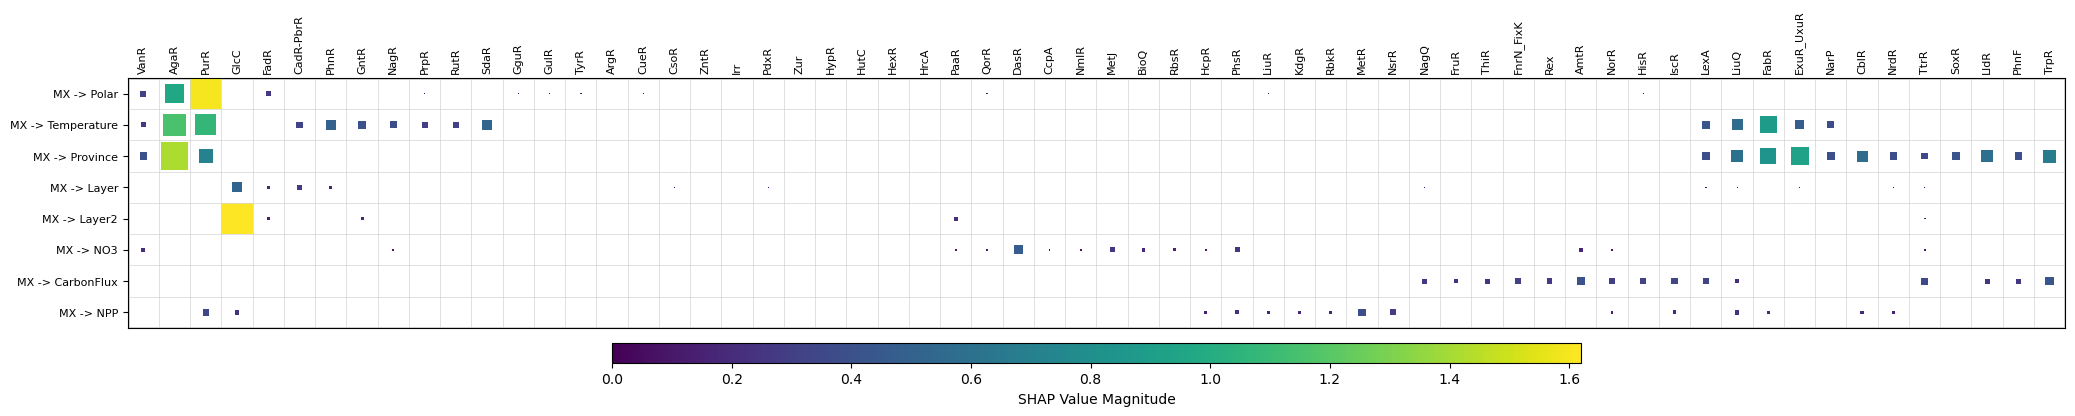

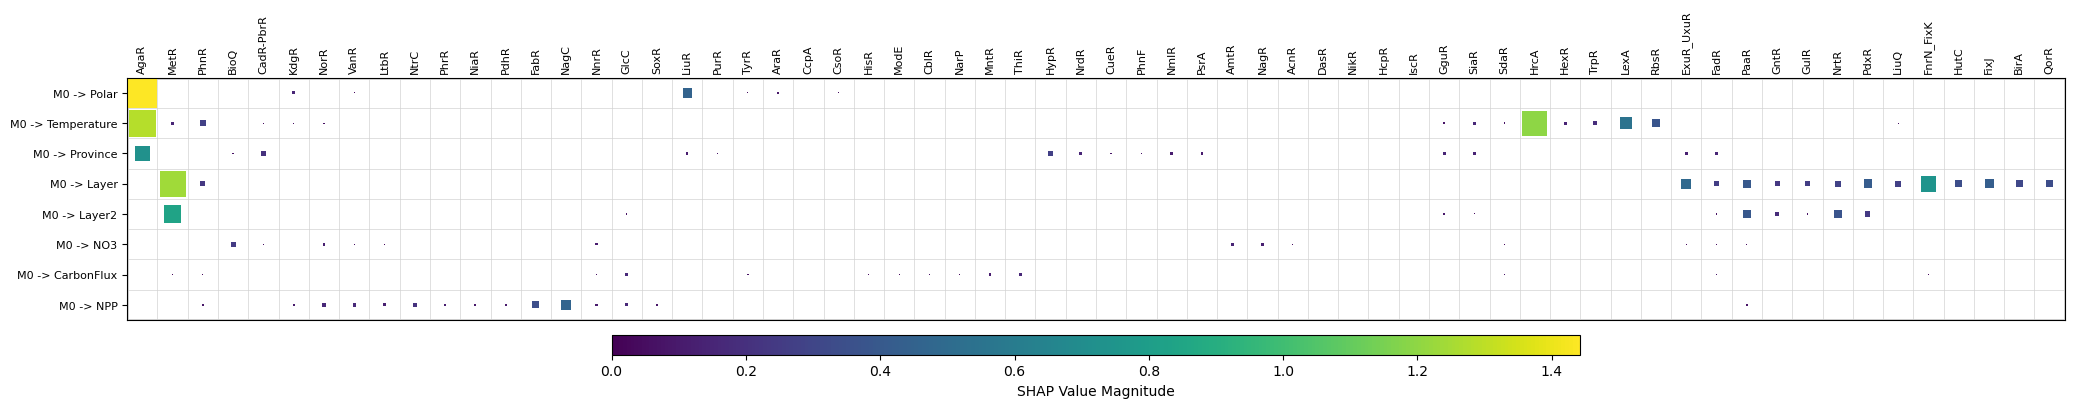

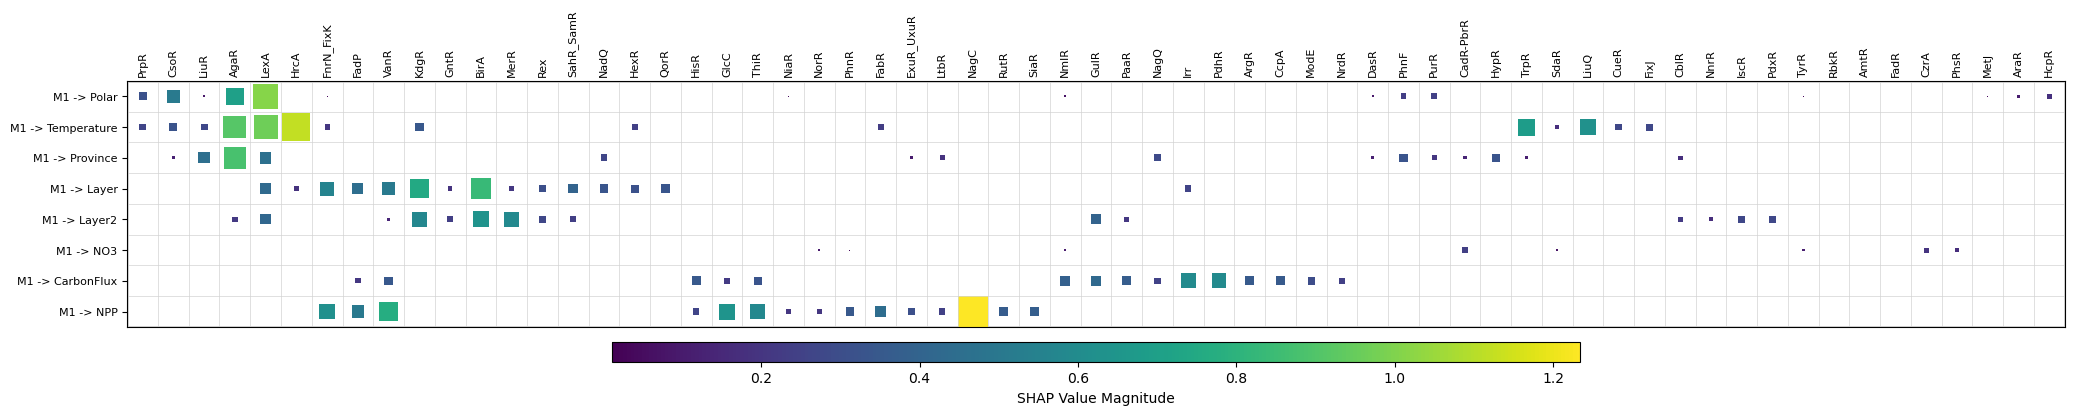

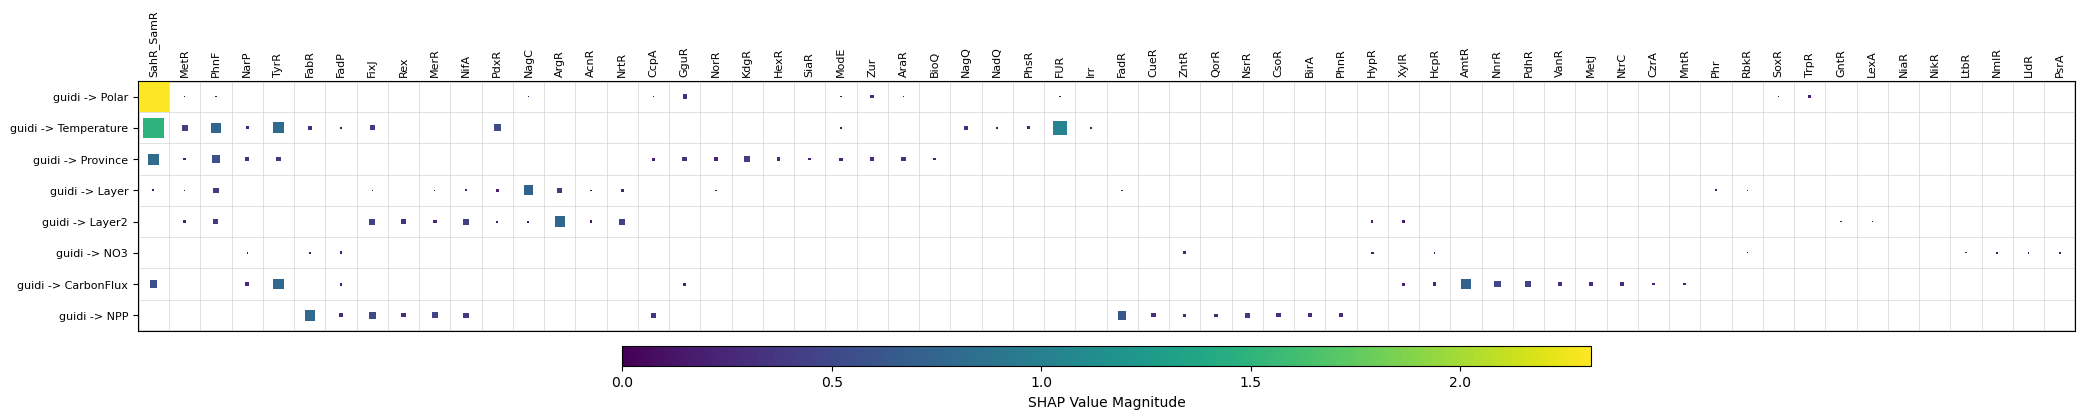

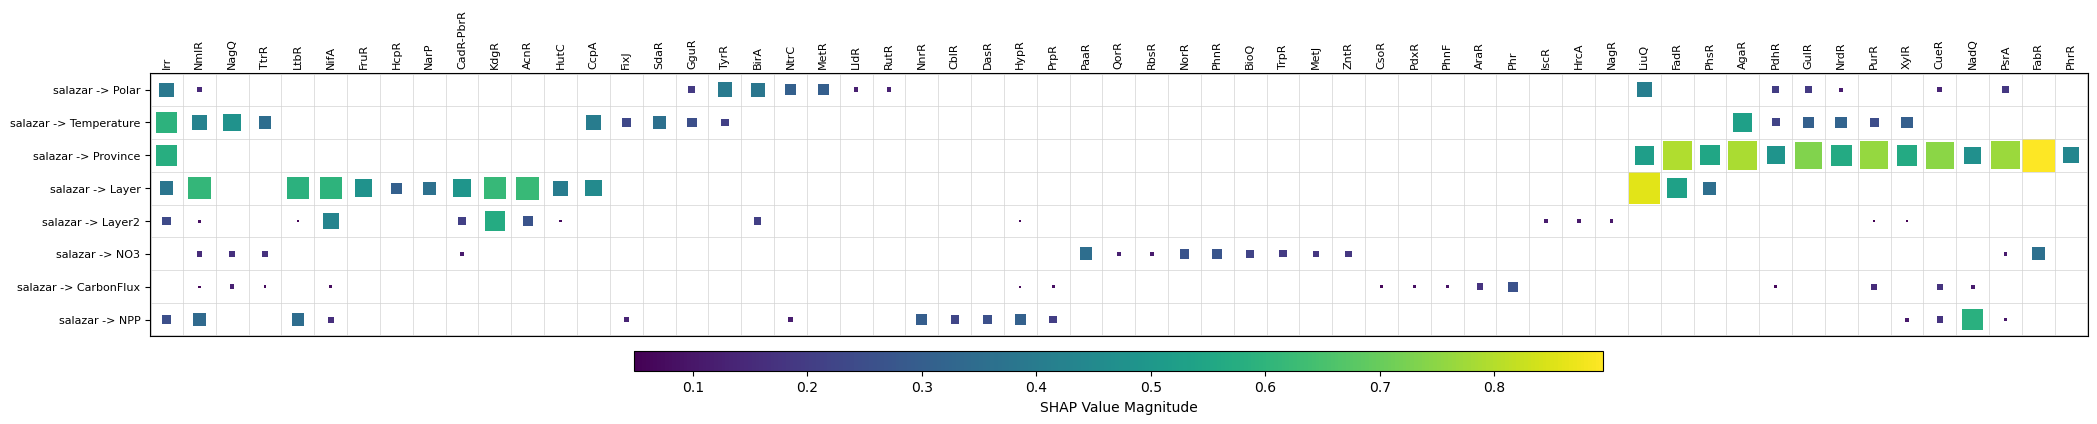

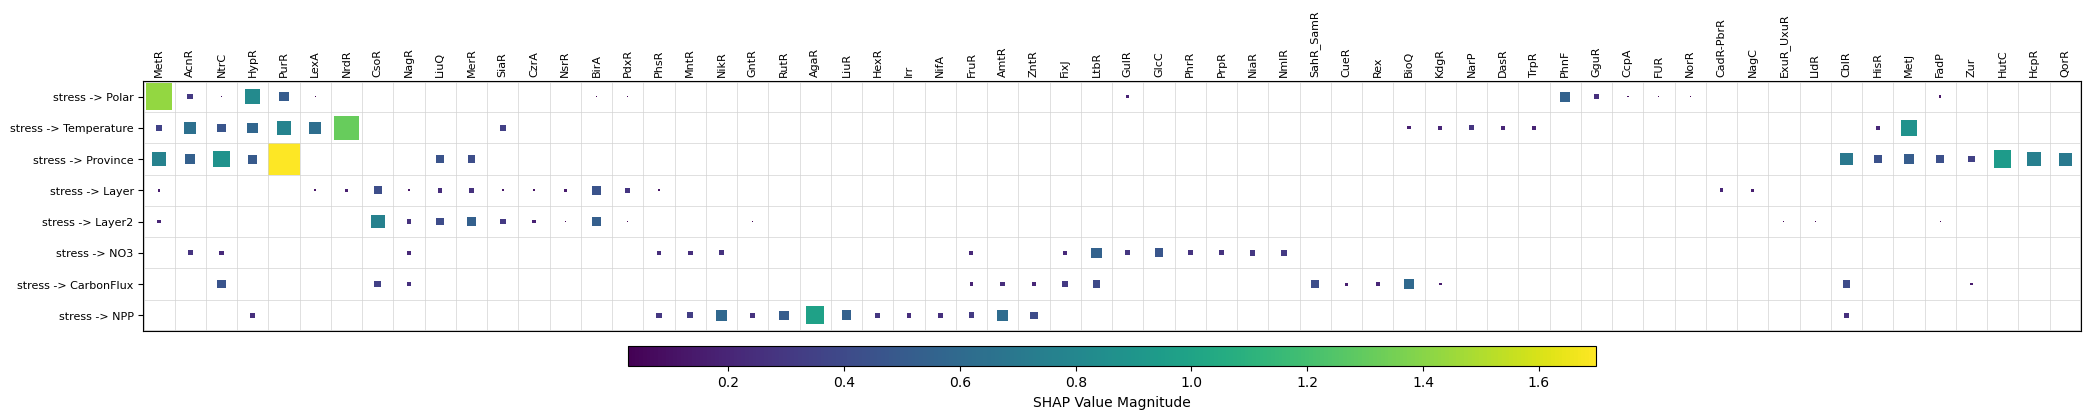

In [37]:
df = pd.read_csv('matrices2/Matrix_MX_all.tsv', sep='\t', index_col=[0])
feature_subset = df.columns  # This should be adjusted if different matrix types have different features

for matrix_type in matrix_types:
    plot_shap_clustermap(matrix_type, data_tests, feature_subset)

In [40]:
results_cflux_total

{'MX': LiuQ         0.226509
 FruR         0.238410
 ThiR         0.252920
 PhnF         0.261303
 LldR         0.262908
 NagQ         0.265290
 Rex          0.279764
 NorR         0.294140
 FnrN_FixK    0.311997
 HisR         0.317915
 LexA         0.323120
 IscR         0.336592
 TtrR         0.359669
 AmtR         0.405879
 TrpR         0.435344
 dtype: float32,
 'M0': MetR         0.032077
 SoxR         0.032976
 FnrN_FixK    0.035499
 ModE         0.037597
 PhnR         0.038738
 NarP         0.043555
 HisR         0.051638
 NnrR         0.060276
 CblR         0.066178
 TyrR         0.068815
 SdaR         0.076132
 FadR         0.080593
 MntR         0.117414
 ThiR         0.160092
 GlcC         0.164942
 dtype: float32,
 'M1': FadP    0.211623
 GlcC    0.222247
 NrdR    0.244928
 NagQ    0.253348
 ModE    0.296377
 ThiR    0.327017
 VanR    0.341426
 HisR    0.350357
 CcpA    0.350494
 ArgR    0.353801
 PaaR    0.365581
 NmlR    0.383125
 GulR    0.425861
 Irr     0.589775
 PdhR 

## Test

In [ ]:
import pandas as pd


# Assuming each results dictionary is formatted as {'MX': series_data, 'M0': series_data, etc.}
results_dict = {
    'results_polar_total': "Polar",
    'results_temperature_total': "Temperature",
    'results_province_total': "Province",
    'results_layer_total': "Layer",
    'results_layer2_total': "Layer2",
    'results_no3_total': "NO3",
    'results_cflux_total': "CarbonFlux",
    'results_npp_total': "NPP"
}

matrix_types = ['MX', 'M0', 'M1', 'guidi', 'salazar', 'stress']  # List all matrix types you have
data_tests = {f"data_test_{type}": {} for type in matrix_types}

for dict_name, analysis_type in results_dict.items():
    current_dict = eval(dict_name)  # Get the dictionary
    for matrix_type, series in current_dict.items():
        if matrix_type in matrix_types:
            key = f"{matrix_type} -> {analysis_type}"
            data_tests[f"data_test_{matrix_type}"][key] = series

df = pd.read_csv('matrices2/Matrix_MX_all.tsv', sep='\t', index_col=[0])
feature_subset = df.columns

# Convert data_test_MX dictionary to DataFrame and reindex
shap_summary_df_MX = pd.DataFrame(data_tests['data_test_MX']).reindex(feature_subset, axis=0).T
shap_summary_df_MX_filled = shap_summary_df_MX.fillna(-1)

clustermap = sns.clustermap(shap_summary_df_MX_filled,
                            method='average', metric='euclidean',
                            cmap='viridis', figsize=(25, 10),
                            row_cluster=False, col_cluster=True)
plt.close(clustermap.fig)

ordered_cols = clustermap.dendrogram_col.reordered_ind
shap_summary_df_ordered = shap_summary_df_MX.iloc[:, ordered_cols].dropna(axis=1, how='all')

max_abs_shap_value = np.nanmax(np.abs(shap_summary_df_ordered.values))

# Create a white grid with the same dimensions as the SHAP summary DataFrame
fig, ax = plt.subplots(figsize=(25, 10))
ax.set_facecolor('white')
ax.imshow(np.ones_like(shap_summary_df_ordered), cmap='gray_r', interpolation='nearest', aspect='equal')

# Set the tick labels and rotation for the x and y axes
ax.set_xticks(np.arange(len(shap_summary_df_ordered.columns)))
ax.set_yticks(np.arange(len(shap_summary_df_ordered.index)))
ax.tick_params(axis='x', which='both', labelbottom=False, labeltop=True, bottom=False, top=True, length=0)
ax.set_yticklabels(shap_summary_df_ordered.index, fontsize=8, color="black")
ax.set_xticklabels(shap_summary_df_ordered.columns, fontsize=8, color="black", rotation=90)

# Create grid lines between the tick labels
ax.set_xticks(np.arange(len(shap_summary_df_ordered.columns) + 1) - .5, minor=True)
ax.set_yticks(np.arange(len(shap_summary_df_ordered.index) + 1) - .5, minor=True)
ax.grid(which="minor", color="lightgray", linestyle="-", linewidth=0.5)
ax.tick_params(which="minor", size=0)

# Add rectangle around the grid
rect = plt.Rectangle((-.5, -.5), len(shap_summary_df_ordered.columns), len(shap_summary_df_ordered.index), linewidth=2, edgecolor='lightgray', facecolor='none')
ax.add_patch(rect)

# Create squares with color proportional to the SHAP values
for i in range(len(shap_summary_df_ordered.columns)):
    for j in range(len(shap_summary_df_ordered.index)):
        value = shap_summary_df_ordered.iat[j, i]
        norm = plt.Normalize(shap_summary_df_ordered.min().min(), shap_summary_df_ordered.max().max())
        sm = plt.cm.ScalarMappable(norm=norm, cmap='viridis')
        color = sm.to_rgba(value)
        size = np.abs(value) / max_abs_shap_value * 1  # Fixed size for all squares for simplicity, adjust as needed
        rect = Rectangle(xy=(i - size / 2, j - size / 2), width=size, height=size, facecolor=color)
        ax.add_patch(rect)
        #ax.text(i, j, f'{value:.2f}', ha='center', va='center', fontsize=7, color="black" if abs(value) < 0.5 else "white")

min_val = np.nanmin(shap_summary_df_ordered.values)
max_val = np.nanmax(shap_summary_df_ordered.values)

# Add color bar
cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', shrink=0.5, aspect=50, pad=0.02)
cbar.set_label('SHAP Value Magnitude')
cbar.set_ticks([min_val, max_val])

plt.savefig('shap_MX_best_tfs_clustermap_test.pdf', bbox_inches='tight')
plt.show()